In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from typing import Union

In [2]:
train = pd.read_csv("res/train.csv")
test = pd.read_csv("res/test.csv")
display(train, test)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X_train = train.drop("label", axis=1).to_numpy() / 255
y_train = train["label"].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
X_test = test.to_numpy() / 255
X_train, X_val, X_test = X_train.reshape(-1, 1, 28, 28), X_val.reshape(-1, 1, 28, 28), X_test.reshape(-1, 1, 28, 28)
if torch.cuda.is_available():
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float).cuda(), torch.tensor(y_train).cuda()), batch_size=500, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float).cuda(), torch.tensor(y_val).cuda()), batch_size=500, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float).cuda()), batch_size=500, shuffle=False)
else:
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train)), batch_size=500, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float), torch.tensor(y_val)), batch_size=500, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float)), batch_size=500, shuffle=False)
print(X_train.shape, X_val.shape, X_test.shape)

(29400, 1, 28, 28) (12600, 1, 28, 28) (28000, 1, 28, 28)


In [4]:
# Samples for visualization including an image of each label
X_sample = []
y_sample = np.arange(10)
for label in range(10):
    img = train[train["label"] == label].drop("label", axis=1).to_numpy()[0, :].reshape(1, 28, 28).tolist()
    X_sample.append(img)
X_sample = np.array(X_sample) / 255

if torch.cuda.is_available():
    sample_loader = DataLoader(TensorDataset(torch.tensor(X_sample, dtype=torch.float).cuda(), torch.tensor(y_sample).cuda()), batch_size=1, shuffle=False)
else:
    sample_loader = DataLoader(TensorDataset(torch.tensor(X_sample, dtype=torch.float), torch.tensor(y_sample)), batch_size=1, shuffle=False)

In [5]:
# Visualization
def show(image: Union[torch.Tensor, np.ndarray]) -> None:
    if type(image) == type(torch.Tensor()):
        image = image.detach().numpy()
    if image.ndim != 2:
        print(f"Dimension of the image is {image.ndim}.")
        image = np.squeeze(image, axis=0)
        channels, _, _ = image.shape

        for channel in range(channels):
            plt.imshow(image[channel], cmap=plt.cm.binary, interpolation="nearest")
            plt.axis("off")
            plt.show()
    else:
        plt.imshow(image, cmap=plt.cm.binary, interpolation="nearest")
        plt.axis("off")
        plt.show()

class Visualizer:
    
    def __init__(self, nrows, ncols, image: torch.Tensor, figsize=(10, 10)):
        self.fig, self.ax = plt.subplots(nrows, ncols, figsize=figsize)
        self.depth = 1
        self.nrows = nrows
        self.ncols = ncols
        
        for row in range(nrows):
            for col in range(ncols):
                self.ax[row, col].axis("off")
                self.ax[row, col].imshow(np.array([[0, 0],[0, 0]]), cmap=plt.cm.binary, interpolation="nearest")
        
        image = np.squeeze(np.squeeze(image.detach().numpy(), axis=0), axis=0)
        self._draw_original_image(image, int(self.nrows / 2), 0)
        
    def _draw_original_image(self, image: np.ndarray, nrow, ncol):
        self.ax[nrow, ncol].imshow(image, cmap=plt.cm.binary, interpolation="nearest")
    
    def draw_feature_maps(self, features: torch.Tensor):
        features = features.detach().numpy()
        features = np.squeeze(features, axis=0)
        channels, _, _ = features.shape
        pos = int((self.nrows - channels) / 2)
        
        for channel in range(channels):
            self.ax[channel + pos, self.depth].imshow(features[channel], cmap=plt.cm.binary, interpolation="nearest")
        
        self.depth += 1
    
    def draw_linear(self, features: torch.Tensor):
        features = features.detach().numpy()
        row = int(self.nrows / 2)
        self.ax[row, self.depth].imshow(features, cmap=plt.cm.binary, interpolation="nearest")
        self.ax[row, self.depth].axis("on")
        self.ax[row, self.depth].set_xticks(range(10))
        self.ax[row, self.depth].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
        self.depth += 1
    
    def show(self):
        self.fig.tight_layout()
        plt.show()

In [6]:
class MNISTClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 5, 3)
        self.conv2 = nn.Conv2d(5, 9, 3)
        self.linear = nn.Linear(9 * 24 * 24, 10)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.conv2(x)
        x = x.view(-1, 9 * 24 * 24)
        x = F.relu(self.linear(x))
        return x
    
    def show(self, x: torch.Tensor) -> None:
        visualizer = Visualizer(9, 4, x)
        x = self.conv(x)
        visualizer.draw_feature_maps(x)
        x = self.conv2(x)
        visualizer.draw_feature_maps(x)
        x = x.view(-1, 9 * 24 * 24)
        x = F.relu(self.linear(x))
        visualizer.draw_linear(x)
        print("Prediction", torch.max(x, 1)[1].item())
        visualizer.show()

if torch.cuda.is_available():
    mnist_classifier = MNISTClassifier().cuda()
else:
    mnist_classifier = MNISTClassifier()

Loss at epoch 1: 0.3434791564941406
Loss at epoch 2: 0.29719582200050354, -0.046
Loss at epoch 3: 0.2843937575817108, -0.013
Loss at epoch 4: 0.26339098811149597, -0.021
Loss at epoch 5: 0.2512514889240265, -0.012
Loss at epoch 6: 0.24361146986484528, -0.008
Loss at epoch 7: 0.267978698015213, 0.024
Loss at epoch 8: 0.2762088477611542, 0.008
Loss at epoch 9: 0.2106037586927414, -0.066
Loss at epoch 10: 0.2716508209705353, 0.061
Accuracy of the network on the 12600 validation images: 90.86%


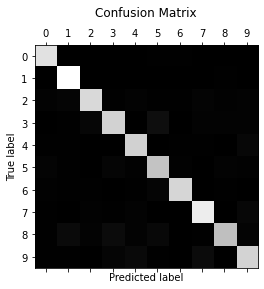

In [7]:
# hyperparameters
lr = 0.005
epoch = 10
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_classifier.parameters(), lr=lr)

# training
for e in range(epoch):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = mnist_classifier(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
    if e == 0:
        print(f"Loss at epoch {e + 1}: {loss.item()}")
    else:
        print(f"Loss at epoch {e + 1}: {loss.item()}, {round(loss.item() - loss_before, 3)}")
    loss_before = loss.item()

# validation
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = mnist_classifier(inputs)
        _, predicted = torch.max(outputs, 1)
        for label, pred in zip(labels.numpy().tolist(), predicted.numpy().tolist()):
            y_true.append(label)
            y_pred.append(pred)

print(f"Accuracy of the network on the {len(y_true)} validation images: {round(accuracy_score(y_true, y_pred) * 100, 2)}%")
conf_mat = confusion_matrix(y_true, y_pred)
plt.matshow(conf_mat, cmap=plt.cm.gray)
plt.title("Confusion Matrix", y=1.1)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()

Label 0
Prediction 0


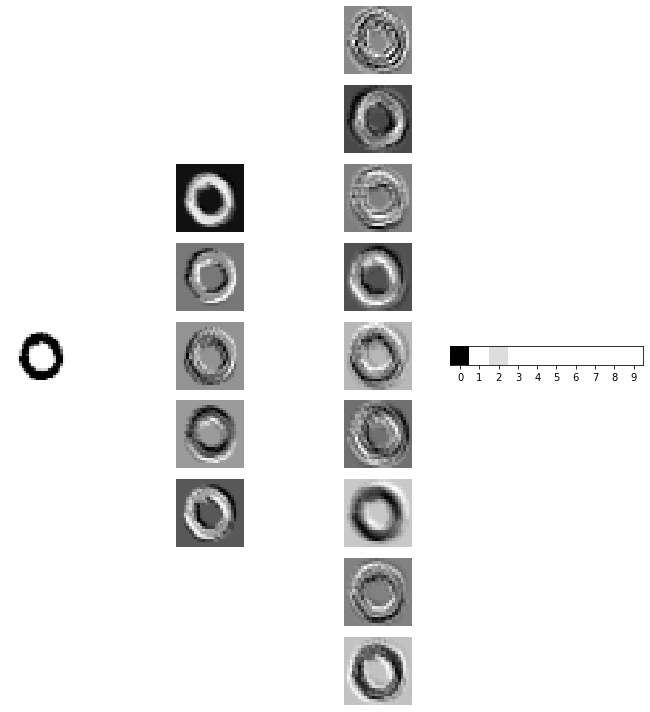

Label 1
Prediction 1


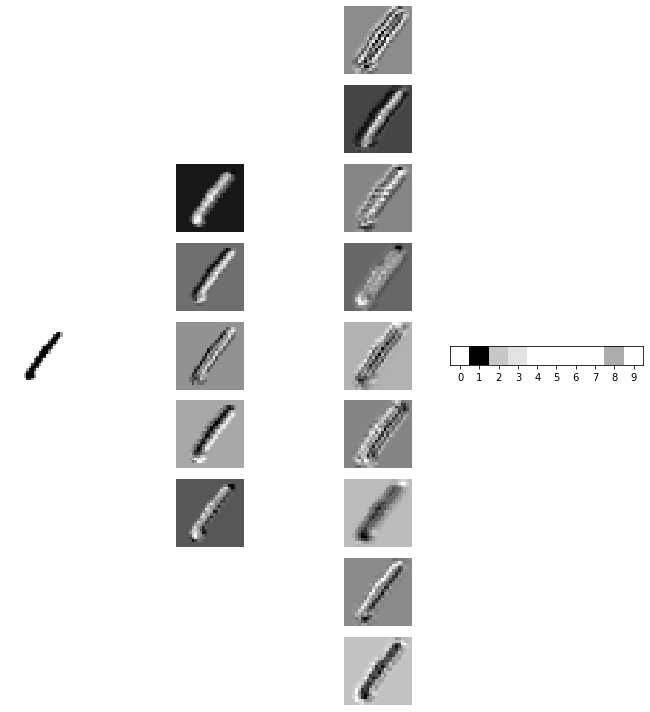

Label 2
Prediction 2


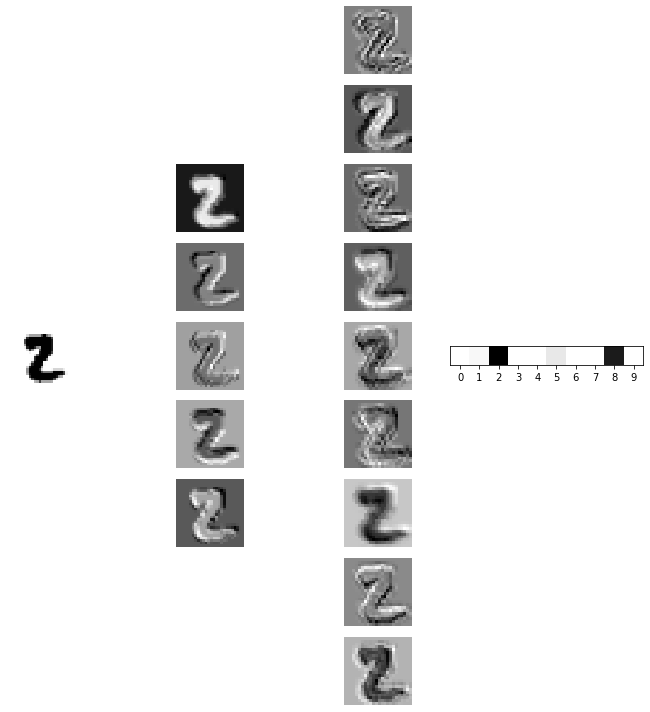

Label 3
Prediction 3


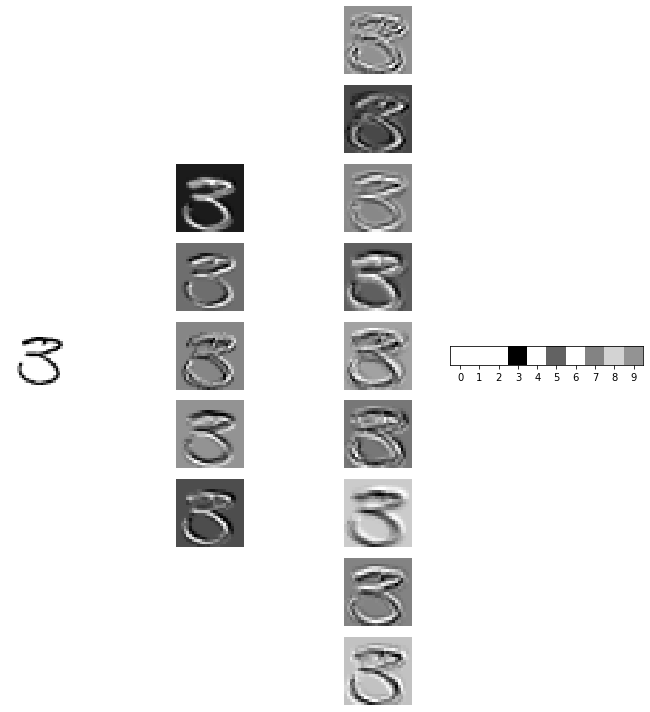

Label 4
Prediction 4


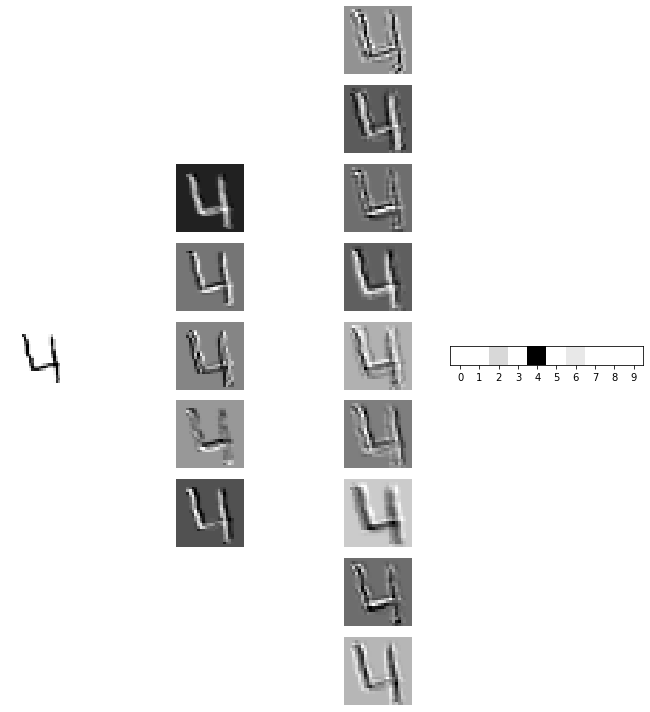

Label 5
Prediction 5


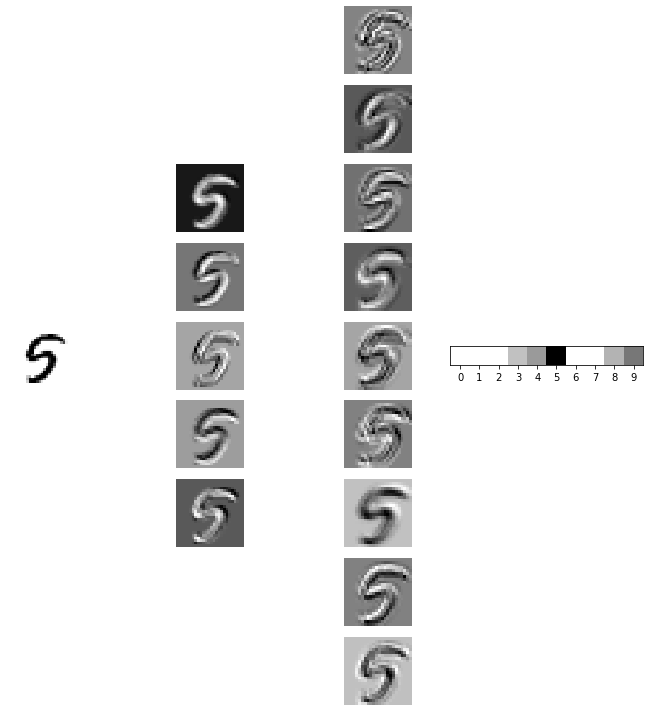

Label 6
Prediction 6


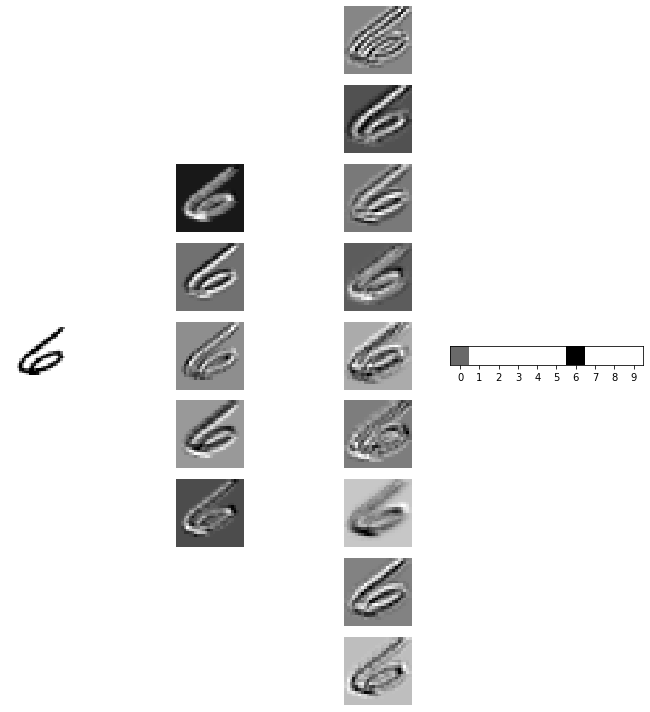

Label 7
Prediction 7


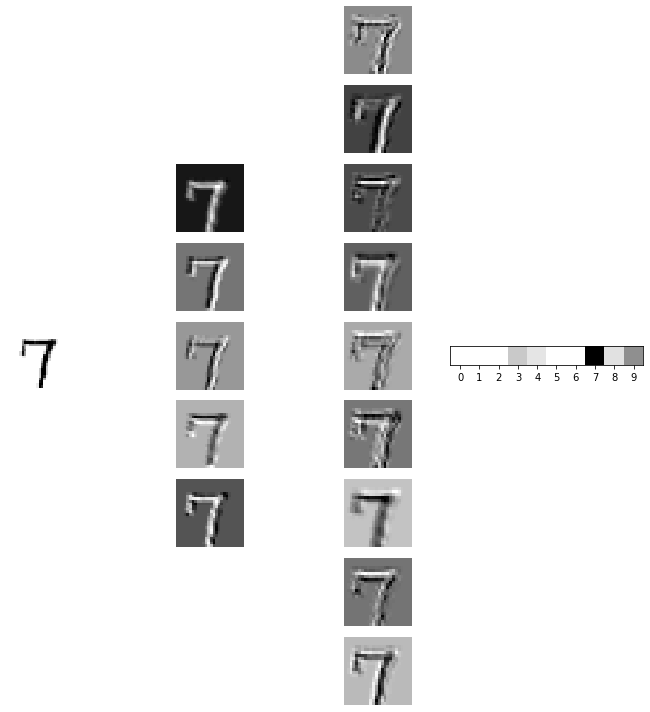

Label 8
Prediction 8


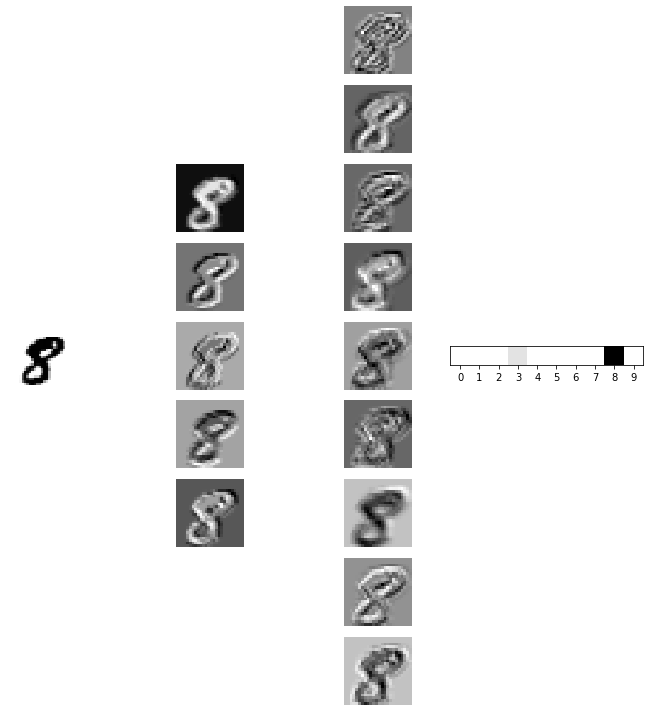

Label 9
Prediction 9


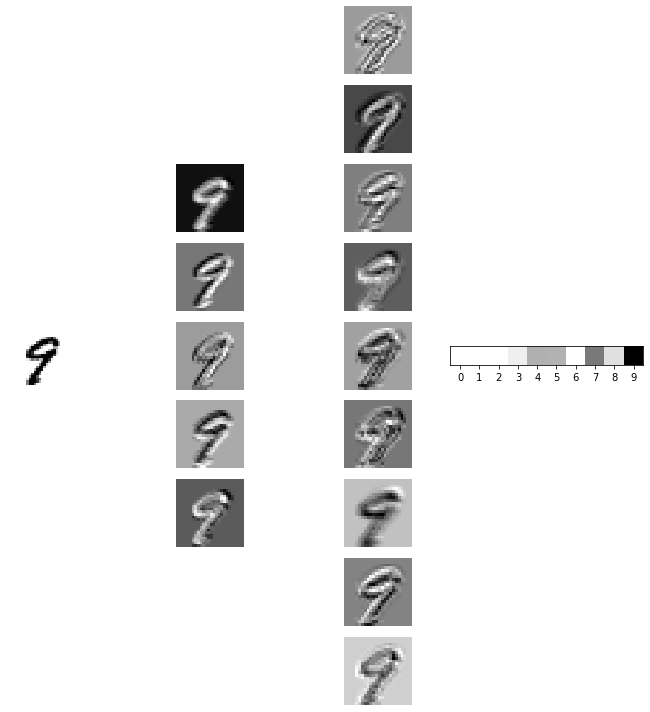

In [8]:
for inputs, labels in sample_loader:
    print("Label", labels.item())
    mnist_classifier.show(inputs)